In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass

%matplotlib inline

In [43]:
facs = pd.read_csv('C:\\Users\\stephanies\Desktop\\facs_shiny.csv')
facs['cluster_label']

0            Pvalb Tpbg
1        Vip Chat Htr1f
2            Lamp5 Lsp1
3       Sst Hpse Sema3c
4        Vip Pygm C1ql1
             ...       
6120        Pvalb Vipr2
6121     Vip Chat Htr1f
6122        Pvalb Vipr2
6123         Lamp5 Lsp1
6124      Vip Lmo1 Myl1
Name: cluster_label, Length: 6125, dtype: object

In [19]:
genes = pd.read_csv('C:\\Users\\stephanies\\Desktop\\mouse_VISp_gene_expression_matrices_2018-06-14\\mouse_VISp_2018-06-14_genes-rows.csv')
genes.head()

,gene_symbol,gene_id,chromosome,gene_entrez_id,gene_name
0,0610005C13Rik,500717483,7,71661,RIKEN cDNA 0610005C13 gene
1,0610006L08Rik,500717917,7,76253,RIKEN cDNA 0610006L08 gene
2,0610007P14Rik,500730104,12,58520,RIKEN cDNA 0610007P14 gene
3,0610009B22Rik,500726890,11,66050,RIKEN cDNA 0610009B22 gene
4,0610009E02Rik,500702775,2,100125929,RIKEN cDNA 0610009E02 gene


In [42]:
patchseq_shiny = pd.read_csv('C:\\Users\\stephanies\\Desktop\\patchseq_shiny.csv')
patchseq_shiny['Tree_first_cl_label']

0          L2/3 IT VISp Rrad
1          L2/3 IT VISp Rrad
2          L2/3 IT VISp Rrad
3          L2/3 IT VISp Rrad
4          L2/3 IT VISp Rrad
                ...         
1425        Pvalb Reln Itm2a
1426         L5 PT VISp Lgr5
1427    L6 CT VISp Nxph2 Wls
1428         L6 IT VISp Car3
1429             Pvalb Vipr2
Name: Tree_first_cl_label, Length: 1430, dtype: object

In [69]:
from aisynphys.cell_class import CellClass

sst_class = CellClass(mapped_subclass='sst', name='sst', tree_call=['Core', 'I1', 'I2', 'I3'])
q = db.pair_query(pre_class=sst_class, post_class=sst_class, project_name='patch-seq', synapse=True)
sst_pairs = q.all()
cell_ids = [(pair.pre_cell_id, pair.post_cell_id) for pair in sst_pairs]
sst_cells_with_synapse = list(set(sum(cell_ids, ())))


q2 = db.query(db.PatchSeq.tube_id, db.PatchSeq.mapped_subclass)
q2 = q2.filter(db.PatchSeq.cell_id.in_(sst_cells_with_synapse))
sst_cells = q2.dataframe()
sst_cells

,tube_id,mapped_subclass
0,PMS4_200903_025_A01,sst
1,PMS4_200903_026_A01,sst
2,PMS4_200226_027_A01,sst
3,PMS4_200226_028_A01,sst
4,PMS4_200211_227_A01,sst
5,PMS4_200211_228_A01,sst


In [70]:
import pandas as pd

sst_cells_dict = {}
for pair in sst_pairs:
    for pre_post, cell in zip(['pre', 'post'], [pair.pre_cell, pair.post_cell]):
        layer = cell.cortical_location.cortical_layer if cell.cortical_location is not None else cell.target_layer
        sst_cells_dict[cell.id] = {
            'pair_id': pair.id,
            'sample_id': cell.patch_seq.tube_id,
            'subclass_label': cell.patch_seq.mapped_subclass,
            'layer': layer,
            'pre_post': pre_post,
            'tree_call': cell.patch_seq.tree_call,
            'cluster_label': cell.patch_seq.cluster_label,
            'cluster_detail': cell.patch_seq.cluster_detail,
            'res_index': cell.patch_seq.res_index,
            'ttype': cell.patch_seq.t_type,
            'tree_first_cluster': cell.patch_seq.tree_first_cluster,
            'tree_first_bt': cell.patch_seq.tree_first_bt,
            'pair_cell_id': pair.post_cell.id if pre_post=='pre' else pair.pre_cell.id
        }
        
sst_cells_df = pd.DataFrame.from_dict(sst_cells_dict, orient='index')
sst_cells_df = sst_cells_df.reset_index().rename(columns={'index': 'cell_id'})
sst_cells_df

,cell_id,pair_id,sample_id,subclass_label,layer,pre_post,tree_call,cluster_label,cluster_detail,res_index,ttype,tree_first_cluster,tree_first_bt,pair_cell_id
0,19819,108498,PMS4_200211_228_A01,sst,4,pre,I2,n107,n_Sst,0.868238,None,Sst Hpse Cbln4,0.56,19818
1,19818,108498,PMS4_200211_227_A01,sst,3,post,Core,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,1.000000,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,0.90,19819
2,19997,109221,PMS4_200226_027_A01,sst,2/3,pre,I3,n91,n_Sst,0.714428,None,Sst Tac1 Tacr3,0.34,19999
3,19999,109221,PMS4_200226_028_A01,sst,2/3,post,I2,n91,n_Sst,0.714428,None,Sst Tac1 Tacr3,0.42,19997
4,20718,111851,PMS4_200903_026_A01,sst,2/3,pre,I1,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,1.000000,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,0.89,20716
5,20716,111851,PMS4_200903_025_A01,sst,2/3,post,I2,n91,n_Sst,0.714428,None,Sst Tac1 Tacr3,0.43,20718


In [71]:
mpatch_cells = sst_cells.rename(columns={'tube_id': 'sample_id', 'mapped_subclass':  'subclass_label'})
mpatch_cells['subclass_label'] = mpatch_cells['subclass_label'].str.capitalize()
mpatch_cells

,sample_id,subclass_label
0,PMS4_200903_025_A01,Sst
1,PMS4_200903_026_A01,Sst
2,PMS4_200226_027_A01,Sst
3,PMS4_200226_028_A01,Sst
4,PMS4_200211_227_A01,Sst
5,PMS4_200211_228_A01,Sst


In [72]:
def dict_from_facs(facs_anno_df, key_column="cluster_label", value_column="subclass_label"):
    """ Create a dict of cluster/label values
    Parameters
    ----------
    facs_anno_df: DataFrame
        FACS annotation information
    key_column: str (optional, default "cluster_label")
        Name of column to be keys of dictionary
    value_column: str (optional, default "subclass_label")
        Name of column to be values of dictionary
    Returns
    -------
    dict
    """

    info = facs_anno_df.loc[:, [key_column, value_column]].drop_duplicates()
    result = dict(zip(info[key_column].tolist(), info[value_column].tolist()))
    return result

def get_tx_masks(tx_anno_df, specimens_file, required_tree_calls, required_subclasses):
    """Get various masks to limit transcriptomic data by specific inclusion criteria.
    
    Parameters
    ----------
        tx_anno_df (Pandas DataFrame): transcriptomic annotations
        specimens_file (str or None): txt file with specimens to use (optional)
        required_tree_calls (list of strings or None): tree call categories to restrict data (optional)
        required_subclasses (list of strings or None): transcriptomic subcalsses to restrict data (optional)
    """
    if required_tree_calls is not None and len(required_tree_calls) > 0:
        tree_mask = tx_anno_df["Tree_call_label"].isin(required_tree_calls).values
    else:
        tree_mask = np.ones(tx_anno_df.shape[0], dtype=bool)
    
    if required_subclasses is not None and len(required_subclasses) > 0:
        temp = tx_anno_df.copy()
        subclass_mask = temp["subclass"].isin(required_subclasses).values
    else:
        subclass_mask = np.ones(tx_anno_df.shape[0], dtype=bool)

    if specimens_file is not None:
        with open(specimens_file, 'r') as tf:
            str_ids = tf.readlines()
        specimen_ids = [int(s_id) for s_id in str_ids]
        specimens_mask = tx_anno_df["spec_id_label"].apply(int).isin(specimen_ids).values
    else:
        specimen_ids = None
        specimens_mask = np.ones(tx_anno_df.shape[0], dtype=bool)

    return tree_mask, subclass_mask, specimens_mask

def reduce_tx_dims(n_dims, data, scale_features=False):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    X = data.values
    
    if scale_features == True:
        X = StandardScaler().fit_transform(X)
        print("Standardizing featues with StandardScaler")
    
    print(F"Original number of features: {X.shape[1]}")
    pca = PCA(n_components=n_dims, random_state=43)
    X_pca = pca.fit_transform(X)

    print(F"Number of features after PCA: {X_pca.shape[1]}")
    print(F"Total explained variance for {n_dims} components: {sum(pca.explained_variance_ratio_)}")

    return X_pca, pca.explained_variance_ratio_, pca.components_

def get_technical_bias_pcs(scores_df, dataset_1_ix, dataset_2_ix, n_pcs, corr_threshold):
    """[summary]
    
    Parameters
    ----------
        scores_df (Pandas DataFrame): combined PC scores from datasets 1 and 2
        dataset_1_ix (list): cell specimen IDs for dataset 1 (ex Patch-seq)
        dataset_2_ix (list): cell specimen IDs for dataset 2 (ex FACS)
        corr_threshold (float): maximum Pearson PC to dataset label correlation coefficient for PC inclusion in final embedding     
    
    Returns
    -------
        technical_bias_pcs (list): PCs to remove from scores_df
        correlations_series (pandas Series): PC correlations with dataset
    """

    from scipy import stats

    # Binarize label        
    patchseq_label =  list(map(lambda x: 0 if x in dataset_2_ix else (1 if x in dataset_1_ix else None), scores_df.index))
    correlations = list(map(lambda x: stats.pearsonr(scores_df.loc[:, x].values, patchseq_label)[0], np.arange(0,n_pcs,1)))

    # Calculate Pearson correlation coefficient
    correlations_series = pd.Series(data=correlations, index=scores_df.columns)
    correlations_series = correlations_series.abs().sort_values(ascending=False)
    
    # Create a list of PCs to drop, in order
    technical_bias_pcs = correlations_series[correlations_series >= corr_threshold].index.values.tolist()

    return technical_bias_pcs, correlations_series

In [73]:
import os

prefix = '//ALLEN/programs/celltypes/workgroups/rnaseqanalysis/shiny'

ps_dir = prefix + '/patch_seq/star/mouse_patchseq_VISp_current'
facs_dir = prefix + '/facs_seq/Mm_VISp_14236_20180912'

tx_data_file_1 = ps_dir + '/data.feather'
tx_data_file_2 = facs_dir + '/data.feather' 
anno_file_1 = ps_dir + '/anno.feather'
anno_file_2 = facs_dir + '/anno.feather' 
facs_anno_file = facs_dir + '/anno.feather' 
cluster_label_1 = 'Tree_first_cl_label'
cluster_label_2 = 'cluster_label' 
genes_file = prefix + '/Taxonomies/AIT2.3.1/select.markers.rda'
specimens_file_1 = None
specimens_file_2 = None
beta_threshold = 0.425 
log_data = True 
n_pcs = 20
scale_features = False 
corr_threshold = 0.2 
min_dist = 0.4 
n_neighbors = 10
required_tree_calls_1 = ['Core', 'I1', 'I2', 'I3']
required_tree_calls_2 = None
required_subclasses_1 = ['Vip','Sst','Pvalb']
required_subclasses_2 = ['Vip','Sst','Pvalb']
# output_file_nonzero_genes_1, 
# output_file_nonzero_genes_2, 
# output_file_pc_scores,
# output_file_pc_loadings, 
# output_file_pc_variances,
# output_file

In [74]:
import pyreadr

rda_data = pyreadr.read_r(genes_file)
rda_df = rda_data["select.markers"]
rda_df.rename(columns={"select.markers":"Gene"}, inplace=True)

rda_df.head()

,Gene
0,Scrg1
1,Nxph1
2,Krt73
3,Tmem45a
4,Piezo2


In [75]:
import feather
import umap

# def main(tx_data_file_1, tx_data_file_2, anno_file_1, anno_file_2, facs_anno_file, cluster_label_1, cluster_label_2, 
#          genes_file, specimens_file_1, specimens_file_2, beta_threshold, log_data, n_pcs, scale_features, corr_threshold, 
#          min_dist, n_neighbors, required_tree_calls_1, required_tree_calls_2, required_subclasses_1, required_subclasses_2, 
#          output_file_nonzero_genes_1, output_file_nonzero_genes_2, output_file_pc_scores, output_file_pc_loadings, 
#          output_file_pc_variances, output_file, **kwargs):
    
# Load gene info
genes_df = rda_df.copy() #pd.read_csv(genes_file)
if "BetaScore" in genes_df.columns:
    genes_df = genes_df.loc[genes_df["BetaScore"] > beta_threshold, :]
ngenes = genes_df.shape[0]
print("Using {} genes".format(ngenes))
tx_data_columns = ["sample_id"] + genes_df["Gene"].tolist()

# Create t-type to subclass dict
facs_anno_df = feather.read_dataframe(facs_anno_file)
subclass_dict = dict_from_facs(facs_anno_df, key_column="cluster_label", value_column="subclass_label")

# Get data for each dataset
datasets = []
for i, (tx_data_file, anno_file, cluster_label, specimens_file, 
            required_tree_calls, required_subclasses) in enumerate(zip(
            (tx_data_file_1, tx_data_file_2), 
            (anno_file_1, anno_file_2), 
            (cluster_label_1, cluster_label_2), 
            (specimens_file_1, specimens_file_2),
            (required_tree_calls_1, required_tree_calls_2), 
            (required_subclasses_1, required_subclasses_2))):

    print(F"Dataset {i}: {required_subclasses} subclasses and {required_tree_calls}")

    # Load transcriptomic gene data for dataset
    tx_data = pd.read_feather(tx_data_file, columns=tx_data_columns)
    tx_data.set_index("sample_id", inplace=True)
    if log_data == True:
        tx_data_raw = tx_data.copy()
        tx_data = tx_data.applymap(lambda x: np.log2(x+1))

    # Load annotation data for dataset
    tx_anno_df = feather.read_dataframe(anno_file)
    tx_anno_df.loc[:,"subclass"] = tx_anno_df[cluster_label].apply(lambda x: subclass_dict[x] if x in subclass_dict.keys() else "None")

    # Filter data if necessary with tree call, subclass and specimen list masks
    tree_mask, subclass_mask, specimens_mask = get_tx_masks(tx_anno_df, specimens_file, required_tree_calls, required_subclasses)
    tx_mask = tree_mask & subclass_mask & specimens_mask
    print(F"Dataset {i} transcriptomic mask sum: {sum(tx_mask)}")
    data = tx_data.loc[tx_mask, :]
    datasets.append(data)

    # Save boolean nonzero gene expression (from pre-log data) for filtered cells and genes
    data_raw = tx_data_raw.loc[tx_mask, :]
#         if i == 0:
#             (data_raw != 0).astype(int).to_csv(output_file_nonzero_genes_1)
#         else:
#             (data_raw != 0).astype(int).to_csv(output_file_nonzero_genes_2)

# Combine datasets
combined_df = pd.concat(datasets, axis=0)

# Reduce dimensionality if n_pcs is specified
# Save PCA results
if n_pcs is not None:
    print(F"Running PCA to reduce dimensionality to {n_pcs}")
    scores, explained_variances, loadings = reduce_tx_dims(n_pcs, combined_df, scale_features=scale_features)
    scores_df = pd.DataFrame(scores, index=combined_df.index)
#         scores_df.to_csv(output_file_pc_scores)
#     pd.DataFrame(data=explained_variances, columns=["explained_variance_ratio"]).to_csv(output_file_pc_variances)
#     pd.DataFrame(loadings, index=np.arange(0,n_pcs,1), 
#         columns=combined_df.columns).to_csv(output_file_pc_loadings)

    # Remove PCs based on correlation with binarized dataset label
    if corr_threshold is not None:
        technical_bias_pcs, correlations = get_technical_bias_pcs(scores_df, datasets[0].index, datasets[1].index, n_pcs, corr_threshold)
        print("Pearson correlation with Patch-seq label:\n"+F"{correlations}"+"\n")

        for i, pc in enumerate(technical_bias_pcs):
            print(F"Removing PC {pc} with {correlations.loc[pc]} correlation coefficent")
            scores_df.drop(columns=pc, inplace=True)
            print(F"Remaining columns: {scores_df.columns}")

    final_df = scores_df
else:
    final_df = combined_df



Using 4020 genes
Dataset 0: ['Vip', 'Sst', 'Pvalb'] subclasses and ['Core', 'I1', 'I2', 'I3']
Dataset 0 transcriptomic mask sum: 5285
Dataset 1: ['Vip', 'Sst', 'Pvalb'] subclasses and None
Dataset 1 transcriptomic mask sum: 4806
Running PCA to reduce dimensionality to 20
Original number of features: 4020
Number of features after PCA: 20
Total explained variance for 20 components: 0.38079109952242324
Pearson correlation with Patch-seq label:
0     0.908603
1     0.257231
19    0.117026
3     0.110715
11    0.074426
4     0.062942
12    0.058613
5     0.035504
15    0.031866
7     0.030804
9     0.017092
16    0.010344
2     0.010261
6     0.008784
10    0.008708
8     0.007745
14    0.007470
13    0.006768
17    0.005246
18    0.000561
dtype: float64

Removing PC 0 with 0.9086028933583755 correlation coefficent
Remaining columns: Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')
Removing PC 1 with 0.2572309845108989 correlation coefficent
Rem

In [76]:
# Perform UMAP embedding on final_data
print(F"Using data with shape {final_df.shape}, min_dist={min_dist} and n_neighbors={n_neighbors} for UMAP embedding")
embedding = umap.UMAP(random_state=42, min_dist=min_dist, n_neighbors=n_neighbors, verbose=True).fit_transform(final_df.values)
out_df = pd.DataFrame(
    {
        "x": embedding[:, 0],
        "y": embedding[:, 1]
    },
    index=final_df.index,
    )

# out_df.to_csv('facs_patchseq_umap.csv')

Using data with shape (10091, 18), min_dist=0.4 and n_neighbors=10 for UMAP embedding
UMAP(min_dist=0.4, n_neighbors=10, random_state=42, verbose=True)
Construct fuzzy simplicial set
Mon Mar 29 11:55:50 2021 Finding Nearest Neighbors
Mon Mar 29 11:55:50 2021 Building RP forest with 10 trees
Mon Mar 29 11:55:51 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
Mon Mar 29 11:56:00 2021 Finished Nearest Neighbor Search
Mon Mar 29 11:56:02 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Mar 29 11:56:08 2021 Finished embedding


No handles with labels found to put in legend.


(-7.514322809710462, 13.25213736689849, -6.692917182088871, 21.35187132561304)

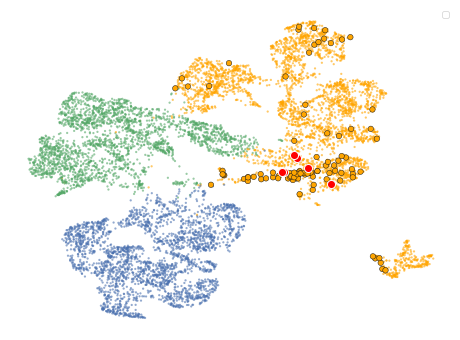

In [81]:
import seaborn as sns
import matplotlib

patchseq_anno_file = anno_file_1
facs_anno_file = anno_file_2
coembedded_umap_file = out_df.copy()

# Set up figure formatting
sns.set(style="white", context="paper", font="Helvetica")
matplotlib.rc('font', family='Helvetica')

# Load data
patchseq_anno_df = feather.read_dataframe(patchseq_anno_file)
patchseq_anno_df.set_index("sample_id", inplace=True, drop=False)
# probabyl somewhere in here is where I'll need to merge a df from our DB that has a column for has_synapse

facs_anno_df = feather.read_dataframe(facs_anno_file)
facs_anno_df.set_index("sample_id", inplace=True, drop=True)

subclass_dict = dict_from_facs(facs_anno_df, key_column="cluster_label", value_column="subclass_label")
ttype_color_dict = dict_from_facs(facs_anno_df, key_column="cluster_label", value_column="cluster_color")            
subclass_color_dict = dict_from_facs(facs_anno_df, key_column="subclass_label", value_column="subclass_color")
subclass_color_dict['Vip'] = '#4c72b0'
subclass_color_dict['Pvalb'] = '#55a868'
subclass_color_dict['Sst'] = 'orange'

merge_color_dict = {}
for subclass in ['Vip', 'Pvalb']: 
    for ttype, color in ttype_color_dict.items():
        if subclass in ttype:
            merge_color_dict[ttype] = subclass_color_dict[subclass]
        elif 'Sst' in ttype:
            merge_color_dict[ttype] = color

ttype_order_dict = dict_from_facs(facs_anno_df, key_column="cluster_label", value_column="cluster_id")

dual_umap_df = coembedded_umap_file
# Co-embedded dataset and t-type labels
dataset_labels = list(map(lambda x: "FACS" if x in facs_anno_df.index else ("Patch-seq" if x in patchseq_anno_df.index else None), dual_umap_df.index))
# and then in here add a synapse column to dual_umap_df

dual_umap_df["dataset"] = dataset_labels
facs_umap_df = dual_umap_df[dual_umap_df["dataset"]=="FACS"]
facs_umap_df = pd.merge(facs_umap_df, facs_anno_df[['subclass_label', 'primary_cluster_label']], on='sample_id', how='left')

patchseq_umap_df = dual_umap_df[dual_umap_df["dataset"]=="Patch-seq"]
patchseq_specimen_ids = patchseq_anno_df["sample_id"]
in_umap_mask = patchseq_specimen_ids.isin(patchseq_umap_df.index.tolist()).values

corei1_mask = patchseq_anno_df["Tree_call_label"].isin(["Core","I1"]).values
combined_corei1_mask = corei1_mask & in_umap_mask
corei1_specimen_ids = patchseq_specimen_ids[combined_corei1_mask]
corei1_umap_df = patchseq_umap_df.loc[corei1_specimen_ids, :]
corei1_umap_df = pd.merge(corei1_umap_df, patchseq_anno_df[['Tree_first_cl_label', 'subclass_label', 'rigNumber_label']],
                                                          on='sample_id', how='left')
mpatch_rigs = ['MP1', 'MP2', 'MP3', 'MP4']
corei1_umap_df['patch_team'] = corei1_umap_df.apply(lambda row: 'SynPhys' if row['rigNumber_label'] in mpatch_rigs else 'other', axis=1)                        
# corei1_ttypes = patchseq_anno_df.loc[corei1_specimen_ids, "Tree_first_cl_label"].values
# corei1_subclass = patchseq_anno_df.loc[corei1_specimen_ids, "subclass_label"].values
# corei1_umap_df["ttype"] = corei1_ttypes
# corei1_umap_df['subclass_label'] = corei1_subclass
sst_umap_df = corei1_umap_df[corei1_umap_df['subclass_label']=='Sst']
pv_vip_umap_df = corei1_umap_df[corei1_umap_df['subclass_label'].isin(['Pvalb', 'Vip'])]

t_types = [
    'Sst Calb2 Pdlim5',
    'Sst Hpse Cbln4',
    'Sst Tac1 Htr1d',
    'Sst Tac1 Tacr3',
]

patchseq_sst_ttype = sst_umap_df[sst_umap_df['Tree_first_cl_label'].isin(t_types)]
# facs_sst_ttype = facs_umap_df[facs_umap_df['primary_cluster_label']=='Sst Tac1 Htr1d']

mpatch_cells_umap = pd.merge(sst_cells_df, patchseq_umap_df[['x', 'y']], on='sample_id', how='left', copy=False)
corei1_mpatch = mpatch_cells_umap[mpatch_cells_umap['tree_call'].isin(['Core', 'I1'])]

fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=facs_umap_df, x="x", y="y", hue="subclass_label", s=5, linewidth=0, 
                    palette=subclass_color_dict, legend=False, ax=ax, alpha=0.6)

sns.scatterplot(data=corei1_umap_df, x="x", y="y", hue='subclass_label', s=5, linewidth=0, palette=subclass_color_dict, ax=ax, 
                legend=False, alpha=0.6)

mpatch_sst = corei1_umap_df[(corei1_umap_df['patch_team']=='SynPhys') & (corei1_umap_df['subclass_label']=='Sst')]

sns.scatterplot(data=mpatch_sst, x="x", y="y", hue='subclass_label', s=30, linewidth=0.5, palette=subclass_color_dict, ax=ax, 
                legend=False, edgecolor='k')

# sns.scatterplot(data=sst_umap_df, x="x", y="y", hue='ttype', s=5, linewidth=0, palette=ttype_color_dict, ax=ax, 
#                 legend=True, alpha=0.)

# sns.scatterplot(data=patchseq_sst_ttype, x="x", y="y", hue='ttype', s=10, linewidth=0, palette=ttype_color_dict, ax=ax, 
#                 legend=True)

# sns.scatterplot(data=facs_sst_ttype, x="x", y="y", hue='primary_cluster_label', s=10, linewidth=0, palette=ttype_color_dict, ax=ax, 
#                 legend=True)

sns.scatterplot(data=mpatch_cells_umap, x="x", y="y", s=65, linewidth=1,
               color='red', legend=False, ax=ax, edgecolor='w')

ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.axis('off')

In [83]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\supplement\\patchseq_umap.svg'
fig.savefig(fname, bbox_inches='tight')

In [228]:
mpatch_cells_umap

,cell_id,sample_id,subclass_label,layer,pre_post,tree_call,cluster_label,cluster_detail,res_index,ttype,tree_first_cluster,tree_first_bt,pair_cell_id,x,y
0,14537,PXS4_190115_155_A01,sst,5,pre,PoorQ,Sst Myh8 Fibin,Sst Myh8 Fibin,1.000000,None,Sst Myh8 Fibin,0.99,14541,NaN,NaN
1,14541,PXS4_190115_156_A01,sst,5,post,PoorQ,n91,n_Sst,0.714428,None,Sst Crhr2 Efemp1,0.26,14537,NaN,NaN
2,14890,PXS4_190204_605_A01,sst,4,pre,I1,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,1.000000,Sst Calb2 Pdlim5,Sst Calb2 Pdlim5,0.87,14888,7.892588,8.111749
3,14888,PXS4_190204_604_A01,sst,2/3,post,PoorQ,n91,n_Sst,0.714428,None,Sst Tac1 Tacr3,0.29,14890,NaN,NaN
4,14947,PXS4_190205_603_A01,sst,5,pre,PoorQ,n91,n_Sst,0.714428,None,Sst Nr2f2 Necab1,0.21,14951,NaN,NaN
5,14951,PXS4_190205_605_A01,sst,5,pre,PoorQ,n91,n_Sst,0.714428,None,Sst Nr2f2 Necab1,0.29,14950,NaN,NaN
6,14950,PXS4_190205_604_A01,sst,5,post,I3,n91,n_Sst,0.714428,None,Sst Tac1 Htr1d,0.30,14951,4.094657,6.538354
7,15018,PXS4_190208_602_A01,sst,5,pre,I1,n107,n_Sst,0.868238,Sst Hpse Cbln4,Sst Hpse Cbln4,0.61,15016,3.953959,6.719816
8,15016,PXS4_190208_601_A01,sst,5,post,PoorQ,n91,n_Sst,0.714428,None,Sst Chrna2 Ptgdr,0.22,15018,NaN,NaN
9,19819,PMS4_200211_228_A01,sst,4,pre,I2,n107,n_Sst,0.868238,None,Sst Hpse Cbln4,0.56,19818,5.354748,7.167807


In [203]:
lines = []
pairs = []
clean_cells = mpatch_cells_umap.dropna()

for i, cell in clean_cells.iterrows():
    pair_cell = clean_cells[clean_cells['pair_cell_id']==cell['cell_id']]
    if len(pair_cell) == 0:
        continue
    pair = (cell.cell_id, pair_cell.cell_id.iloc[0])
    if (pair_cell.cell_id.iloc[0], cell.cell_id) in pairs:
        continue
    pairs.append(pair)
    line = [[cell['x'], pair_cell['x'].iloc[0]], [cell['y'], pair_cell['y'].iloc[0]]]
    lines.append(line)
    

In [286]:
subclass_color_dict

{'Pvalb': '#55a868',
 'L4': '#00979D',
 'Vip': '#4c72b0',
 'L2/3 IT': '#94D9A1',
 'Lamp5': '#DA808C',
 'NP': '#3E9E64',
 'Sst': 'orange',
 'L5 IT': '#008A61',
 'Oligo': '#53776C',
 'L6 CT': '#2D8CB8',
 'L6 IT': '#A19922',
 'Sncg': '#8510C0',
 'Serpinf1': '#A700FF',
 'L5 PT': '#0D5B78',
 'Astro': '#665C47',
 'L6b': '#25596D',
 'Endo': '#8D6C62',
 'Peri': '#665547',
 'Meis2': '#FF0000',
 'Macrophage': '#537358',
 'CR': '#00FF66',
 'VLMC': '#697255',
 'SMC': '#807059'}

In [256]:
corei1_umap_df['patch_team'] = corei1_umap_df.apply(lambda row: 'SynPhys' if row.rigNumber_label in mpatch_rigs else 'other', axis=1)           

AttributeError: ("'Series' object has no attribute 'rigNumber_label'", 'occurred at index P2S4_170807_055_A01')

In [242]:
patchseq_anno_df['rigNumber_label'].unique()

array(['5', '6', '7', '3', 'HCT1', '2', '', 'MP2', 'MP1', 'ZZ_Missing',
       'MP4', 'MP3', '1', '4', 'HCT2', 'HCT3'], dtype=object)

In [259]:
corei1_umap_df.iloc[0]

x                         -2.22638
y                         -3.73788
dataset                  Patch-seq
ttype             Vip Igfbp6 Car10
subclass_label                 Vip
Name: P2S4_170807_055_A01, dtype: object

Connection probability

In [2]:
import numpy as np
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import GaussianModel, pair_distance, measure_connectivity, recip_connectivity_profile, connectivity_profile, distance_adjusted_connectivity
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from aisynphys.ui.notebook import show_connectivity_matrix, show_connectivity_profile, show_connectivity_fit, show_distance_binned_cp, show_connectivity_raster, set_distance_xticks, compose_svg_figure
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
print(db.schema_version)
matplotlib.rcParams['font.sans-serif'] = "Arial"

19


In [3]:
projects = ['mouse V1 coarse matrix', 'mouse V1 pre-production', 'patch-seq']
mouse_pairs = db.pair_query(project_name=projects).all()
print("loaded %d cell pairs" % len(mouse_pairs))

loaded 93824 cell pairs


In [59]:
def check_pair(p, syn_type):
    return (
        # must have been probed for connectivity
        pair_was_probed(p, syn_type) and
        # must have a true/false connection call
        p.has_synapse is not None and
        # intersomatic distance < 500 µm (removes some bad data with very large distances)
        p.distance is not None and 
        p.distance < 500e-6
    )



In [60]:
from aisynphys.connectivity import BinaryModel, ErfModel, pair_was_probed, CorrectionMetricFunctions, ei_correct_connectivity, CorrectionModel

# add correction metrics to mouse pairs
correction_metrics = {
    'pre_axon_length': {'model': BinaryModel, 'init': (0.1, 200e-6, 0.5), 'bounds': ((0.001, 1), (200e-6, 200e-6), (0.1, 0.9))}, 
    'avg_pair_depth': {'model': ErfModel, 'init': (0.1, 30e-6, 30e-6), 'bounds': ((0.01, 1), (10e-6, 200e-6), (-100e-6, 100e-6))},
    'detection_power': {'init': (0.1, 1.0, 3.0), 'model': ErfModel, 'bounds': ((0.001, 1), (0.1, 5), (2, 5)),
                              'constraint': (0.6745, 4.6613)}, 
}



In [61]:
attributes = list(correction_metrics.keys())
extended_pairs = []
for pair in mouse_pairs:
    probe_type = pair.pre_cell.cell_class_nonsynaptic
    if probe_type not in ['ex', 'in']:
        continue
    if not check_pair(pair, probe_type):
        continue
    for attr in attributes:
        attr_func = getattr(CorrectionMetricFunctions, attr)
        val = attr_func(pair)
        setattr(pair, attr, val)
    
    extended_pairs.append(pair)

In [62]:
coarse_sst = [p for p in extended_pairs if p.experiment.project_name != 'patch-seq']
patchseq_sst = [p for p in extended_pairs if p.experiment.project_name == 'patch-seq']

sst_classes = {
    'coarse_sst': (CellClass(cre_type='sst', name='coarse_sst'), coarse_sst),
    'patchseq_sst': (CellClass(mapped_subclass='sst', tree_call=['Core', 'I1', 'I2', 'I3'], name='patchseq_sst'), patchseq_sst),
}

In [67]:
from aisynphys.connectivity import ei_correct_connectivity
ei_classes = {'excit': CellClass(cell_class_nonsynaptic='ex', name='ex'), 'inhib': CellClass(cell_class_nonsynaptic='in', name='in')}

connectivity_results = {}
for sst_class_name, data in sst_classes.items():
    
    sst_class, pairs = data
    
    # Group all cells by selected classes
    cell_groups = classify_cells([sst_class], pairs=pairs, missing_attr='ignore')

    # Group pairs into (pre_class, post_class) groups
    pair_groups = classify_pairs(pairs, cell_groups)

    # perform corrections and add attributes to each pair 

    corr_model = ei_correct_connectivity(ei_classes, correction_metrics, pairs)

    # analyze matrix elements
    connectivity_results.update(measure_connectivity(pair_groups, sigma=100e-6, fit_model=GaussianModel, dist_measure='distance', 
                                            correction_model=corr_model)) 
    
    print(sst_class_name, connectivity_results[(sst_class_name, sst_class_name)]['connectivity_correction_fit']['cp_ci'])
    

coarse_sst (array([0.13716855]), array([0.10521977]), array([0.17540983]))
patchseq_sst (array([0.45289342]), array([0.08736935]), array([1.26090677]))


In [66]:
connectivity_results[('patchseq_sst', 'patchseq_sst')]#['connectivity_correction_fit']['cp_ci']

{'n_probed': 47,
 'n_connected': 3,
 'n_gaps_probed': 37,
 'n_gaps': 0,
 'connection_probability': (0.06382978723404255,
  0.013361769497254926,
  0.17539243001292093),
 'gap_probability': (0.0, 0, 0.09489058741498992),
 'connected_pairs': [<Pair 1582757651.945 3 4>,
  <Pair 1581462686.232 4 2>,
  <Pair 1599165669.424 7 1>],
 'gap_pairs': [],
 'probed_pairs': [<Pair 1568148194.765 4 3>,
  <Pair 1548276956.051 6 4>,
  <Pair 1571170055.006 2 5>,
  <Pair 1571170055.006 5 2>,
  <Pair 1599693252.816 3 8>,
  <Pair 1599693252.816 8 3>,
  <Pair 1544824964.579 8 4>,
  <Pair 1547682908.392 3 4>,
  <Pair 1547682908.392 4 3>,
  <Pair 1547594797.173 8 1>,
  <Pair 1547850437.293 1 8>,
  <Pair 1547850437.293 8 1>,
  <Pair 1548276956.051 1 4>,
  <Pair 1548276956.051 4 1>,
  <Pair 1548276956.051 4 6>,
  <Pair 1548276956.051 6 1>,
  <Pair 1549322153.087 6 4>,
  <Pair 1549492860.363 1 3>,
  <Pair 1582757651.945 3 4>,
  <Pair 1582757651.945 4 3>,
  <Pair 1581375129.740 7 2>,
  <Pair 1581462686.232 4 2>,
 

In [25]:
connectivity_results.keys()

dict_keys([(<CellClass coarse_sst>, <CellClass coarse_sst>), (<CellClass patchseq_sst>, <CellClass patchseq_sst>)])

In [37]:
sst_class = CellClass(mapped_subclass='sst', name='sst')
q = db.pair_query(pre_class=sst_class, post_class=sst_class, project_name='patch-seq', synapse=True)


In [55]:
sst_pairs = [p for p in mouse_pairs if p.id in [108498, 109221, 111851]]

In [58]:
[(pair_was_probed(p, 'in'), p.distance, p.has_synapse) for p in sst_pairs]

[(True, 4.05010981757806e-05, True),
 (True, 9.50712463668115e-05, True),
 (True, 8.59962703713641e-05, True)]

In [57]:
[(p.pre_cell.cortical_location, p.post_cell.cortical_location) for p in sst_pairs]

[(None, None), (None, None), (None, None)]